In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import sys
import os

# Subir tres niveles desde tfm/teams/lille/ hasta data/
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.insert(0, project_root)

from database.connection import get_db_manager

In [2]:
# Configuration
SEASON = '2425'
MIN_MINUTES = 800

# COLORES DE LA PALETA TEAM_COLORS (más cercanos a colores oficiales)
LILLE_COLORS = {
    'primary': '#DC143C',    # Crimson (parecido al rojo Lille #DA291C)
    'secondary': '#000000'   # Black
}

RANGERS_COLORS = {
    'primary': '#004D98',    # Navy Blue (parecido al azul Rangers #0033A0)
    'secondary': '#FF6347'   # Tomato (parecido al rojo Rangers)
}

FW_PLAYERS = [
    {'name': 'Jonathan David', 'search': 'Jonathan David', 'pos': 'FW', 'team': 'Lille', 'table': 'domestic'},
    {'name': 'Hamza Igamane', 'search': 'Igamane', 'pos': 'FW', 'team': 'Rangers', 'table': 'extras'},
]

SAVE_PATH_BASE = "./david_igamane_radars/"
os.makedirs(SAVE_PATH_BASE, exist_ok=True)

In [3]:
# Conexión BD - Combinar domestic (Big 5) + extras (Escocia)
db = get_db_manager()

# Query domestic (Big 5 - David en Lille)
query_domestic = text("""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics,
    'domestic' as source_table
FROM footballdecoded.players_domestic p
WHERE p.season = :season
""")

# Query extras (Liga Escocesa - Igamane en Rangers)
query_extras = text("""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics,
    'extras' as source_table
FROM footballdecoded.players_extras p
WHERE p.season = :season
""")

with db.engine.connect() as conn:
    df_domestic = pd.read_sql(query_domestic, conn, params={'season': SEASON})
    df_extras = pd.read_sql(query_extras, conn, params={'season': SEASON})

# Combinar ambas tablas
df_raw = pd.concat([df_domestic, df_extras], ignore_index=True)

db.close()

print(f"Extraídos: {df_raw.shape[0]} registros, {df_raw.shape[1]} columnas")
print(f"  Domestic: {df_domestic.shape[0]} | Extras: {df_extras.shape[0]}")
df_raw.head()

2026-01-12 15:39:05,917 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-12 15:39:06,119 - database.connection - INFO - Database connection successful


Extraídos: 5258 registros, 11 columnas
  Domestic: 2722 | Extras: 2536


,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics,source_table
0,8721f43840f21e07,Alexsandro Ribeiro,Lille,FRA-Ligue 1,2425,DF,BRA,24.0,"{'FK': '0', 'OG': '1', 'Crs': '8', 'Fld': '32'...","{'understat_xa': '0.6979309292510152', 'unders...",domestic
1,35951d98559bfe76,Tomáš Souček,West Ham,ENG-Premier League,2425,MF,CZE,29.0,"{'FK': '0', 'OG': '0', 'Crs': '14', 'Fld': '25...",{},domestic
2,9674121c8df47df8,Roberto Gagliardini,Monza,ITA-Serie A,2425,"MF,DF",ITA,30.0,"{'FK': '0', 'OG': '0', 'Crs': '1', 'Fld': '7',...","{'understat_xa': '0.0823206976056099', 'unders...",domestic
3,fd2d30be3514c774,Alessandro Bianco,Fiorentina,ITA-Serie A,2425,MF,ITA,21.0,"{'FK': '0', 'OG': '0', 'Crs': '0', 'Fld': '0',...","{'understat_xa': '1.4734479561448097', 'unders...",domestic
4,eee00a885dfc4657,Marc Casado,Barcelona,ESP-La Liga,2425,MF,ESP,20.0,"{'CS': '1', 'FK': '0', 'OG': '0', '/90': '-0.3...","{'understat_xa': '0.0110369473695755', 'unders...",domestic


In [4]:
# Filtrar por minutos mínimos Y posición FW
df_filtered = df_raw[
    (df_raw['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= MIN_MINUTES) &
    (df_raw['position'].str.contains('FW', case=False, na=False))
].copy()

print(f"Filtro {MIN_MINUTES}+ min + FW: {df_filtered.shape[0]} jugadores")
print(f"\nLigas incluidas:")
print(df_filtered['league'].value_counts())

Filtro 800+ min + FW: 915 jugadores

Ligas incluidas:
league
ESP-La Liga           115
NED-Eredivisie        108
ITA-Serie A           104
FRA-Ligue 1           100
ENG-Premier League     98
POR-Primeira Liga      93
BEL-Pro League         88
GER-Bundesliga         86
TUR-Süper Lig          63
SCO-Premiership        60
Name: count, dtype: int64


In [5]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    if value is None or pd.isna(value):
        return np.nan
    if isinstance(value, str):
        if value.strip() == '' or value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    return np.nan

In [6]:
# Extraer métricas numéricas
fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
understat_nums = extract_metrics(df_filtered, 'understat_metrics')
print(f"FBref: {fbref_nums.shape[1]} métricas | Understat: {understat_nums.shape[1]} métricas")

FBref: 185 métricas | Understat: 10 métricas


In [7]:
# ESCOCIA: solo 44 métricas vs 145 Big5
# Usar SOLO métricas comunes Escocia ∩ Big5 (20 relevantes FW)

# Métricas CORE que existen en ambas ligas (Escocia y Big5)
common_metrics_core = [
    'goals', 'assists', 'shots', 'shots_on_target', 'non_penalty_goals',
    'goals_plus_assists', 'penalty_goals', 'penalty_attempts',
    'goals_per_shot', 'goals_per_shot_on_target',
    'SoT/90', 'shots_per_90', 'G+A-PK',
    'Fld', 'Crs', 'interceptions', 'tackles_won', 'Tackles_TklW',
    'Fls', 'Off'
]

# Normalizar per90 solo las que NO son ya ratios
exclude_normalization = {
    'minutes_played', 'age', 'birth_year', 'games_started', 'minutes_per_game',
    'minutes_per_start', 'games', 'games_subs', 'unused_sub', 'points_per_game',
    'on_goals_for', 'on_goals_against', 'plus_minus', 'plus_minus_per90',
    'plus_minus_wowy', 'on_xg_for', 'on_xg_against', 'xg_plus_minus',
    'xg_plus_minus_per90', 'xg_plus_minus_wowy',
    # Ya son ratios o per90
    'goals_per_shot', 'goals_per_shot_on_target', 'SoT/90', 'shots_per_90',
    'G+A-PK', 'shots_on_target_pct', 'matches_played'
}

# Seleccionar solo métricas comunes que existan en fbref_nums
fbref_common = fbref_nums[[col for col in common_metrics_core if col in fbref_nums.columns]]

# Normalizar per90 las que lo necesitan
fbref_to_normalize = fbref_common.loc[:, ~fbref_common.columns.isin(exclude_normalization)]
fbref_per90 = (fbref_to_normalize.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
fbref_per90.columns = [f'{col}_per90' for col in fbref_per90.columns]

# Mantener ratios sin normalizar
fbref_ratios = fbref_common[[col for col in fbref_common.columns if col in exclude_normalization]]

print(f"Métricas comunes (Escocia ∩ Big5): {len(common_metrics_core)}")
print(f"Normalizadas per90: {fbref_per90.shape[1]}")
print(f"Ratios sin normalizar: {fbref_ratios.shape[1]}")

Métricas comunes (Escocia ∩ Big5): 20
Normalizadas per90: 15
Ratios sin normalizar: 5


In [8]:
# COMBINAR todas las métricas (igual que Sorloth/Barry cell 6)
# Incluir métricas base (minutes_played, matches_played) + normalizadas + ratios
base_metrics = fbref_nums[['minutes_played', 'matches_played']].copy()
all_metrics = pd.concat([base_metrics, fbref_per90, fbref_ratios], axis=1)

print(f"Métricas totales antes de percentiles: {all_metrics.shape[1]}")

# Calcular percentiles (igual que Sorloth/Barry cell 7)
all_percentiles = all_metrics.rank(pct=True) * 98 + 1
all_percentiles = all_percentiles.round(0).astype('Int64')
all_percentiles.columns = [f'{col}_pct' for col in all_percentiles.columns]

print(f"Percentiles calculados: {all_percentiles.shape[1]}")

Métricas totales antes de percentiles: 22
Percentiles calculados: 22


In [9]:
# DataFrame final consolidado (igual que Sorloth/Barry cell 8)
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']

df_final = pd.concat([
    df_filtered[base_cols],
    all_metrics,        # Contiene minutes_played, matches_played, per90, ratios
    all_percentiles     # Percentiles para TODAS las métricas
], axis=1)

print(f"DataFrame final: {df_final.shape[0]} filas, {df_final.shape[1]} columnas")

# Limpieza de Series anidados
def clean_series_values(df):
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        if series_mask.any():
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

df_final = clean_series_values(df_final)

print(f"Limpieza completada: {df_final.shape[1]} columnas finales")

DataFrame final: 915 filas, 50 columnas
Limpieza completada: 50 columnas finales


In [10]:
# Search FW players
player_ids = {}

print("FORWARD PLAYER SEARCH:")
print("=" * 50)

for player_config in FW_PLAYERS:
    player_name = player_config['name']
    search_pattern = player_config['search']
    
    search_results = df_filtered[
        df_filtered['player_name'].str.contains(search_pattern, case=False, na=False)
    ]
    
    if len(search_results) > 0:
        print(f"\n{player_name} - search: '{search_pattern}':")
        for _, p in search_results.iterrows():
            minutes = p['fbref_metrics'].get('minutes_played', 0) if isinstance(p['fbref_metrics'], dict) else 0
            print(f"  {p['unique_player_id']} - {p['player_name']} ({p['team']}, {p['league']}, {p['position']}) - {minutes} min")
            
            if player_name not in player_ids:
                player_ids[player_name] = p['unique_player_id']
                print(f"  ✓ ASSIGNED: {player_name} -> {p['unique_player_id']}")
                break
    else:
        print(f"\n{player_name}: NOT FOUND")

print("\n" + "=" * 50)
print("PLAYERS FOUND:")
for name, player_id in player_ids.items():
    print(f"  {name}: {player_id}")

if len(player_ids) == 2:
    print(f"\n✓ ALL PLAYERS FOUND")
else:
    print(f"\n✗ MISSING PLAYERS")

FORWARD PLAYER SEARCH:

Jonathan David - search: 'Jonathan David':
  5988b6b8ef63203f - Jonathan David (Lille, FRA-Ligue 1, FW) - 2554.0 min
  ✓ ASSIGNED: Jonathan David -> 5988b6b8ef63203f

Hamza Igamane - search: 'Igamane':
  cb71bec6439ce5b4 - Hamza Igamane (Rangers, SCO-Premiership, FW,MF) - 1976.0 min
  ✓ ASSIGNED: Hamza Igamane -> cb71bec6439ce5b4

PLAYERS FOUND:
  Jonathan David: 5988b6b8ef63203f
  Hamza Igamane: cb71bec6439ce5b4

✓ ALL PLAYERS FOUND


In [11]:
# FW Centro metrics configuration (usando métricas comunes per90)
fw_metrics = [
    'goals_per90', 'non_penalty_goals_per90', 'shots_per90', 'goals_per_shot',
    'assists_per90', 'goals_plus_assists_per90', 'SoT/90', 'goals_per_shot_on_target',
    'Fld_per90', 'G+A-PK'
]
fw_titles = [
    'Goals', 'Non-Penalty Goals', 'Shots', 'Goals per Shot',
    'Assists', 'Goals + Assists', 'Shots on Target', 'Goals per SoT',
    'Fouls Drawn', 'G+A-PK'
]

METRICS_BY_POSITION = {
    'fw_st': {'metrics': fw_metrics, 'titles': fw_titles}
}

print("FW METRICS VERIFICATION (Common metrics only):")
print("=" * 50)
for position, config in METRICS_BY_POSITION.items():
    metrics_count = len(config['metrics'])
    titles_count = len(config['titles'])
    status = "OK" if metrics_count == 10 and titles_count == 10 else "ERROR"
    print(f"{status} {position}: {metrics_count} metrics, {titles_count} titles")

FW METRICS VERIFICATION (Common metrics only):
OK fw_st: 10 metrics, 10 titles


In [12]:
# David vs Igamane comparison configuration
COMPARISON = {
    'name': 'David_vs_Igamane',
    'player1': 'Jonathan David',
    'player2': 'Hamza Igamane', 
    'position_type': 'FW_ST',
    'metrics_key': 'fw_st',
    'title': 'Jonathan David (Lille) vs Hamza Igamane (Rangers) 24/25',
    'faces': ['/home/jaime/FD/data/blog/caras/tfm/david.png', '/home/jaime/FD/data/blog/caras/tfm/igamane.png'],
    'colors': [LILLE_COLORS['primary'], RANGERS_COLORS['primary']]
}

print(f"COMPARISON: {COMPARISON['title']}")
print(f"\nMETRICS BY POSITION (Common metrics only):")
for position, config in METRICS_BY_POSITION.items():
    metrics_count = len(config['metrics'])
    titles_count = len(config['titles'])
    status = "OK" if metrics_count == 10 and titles_count == 10 else "ERROR"
    print(f"{status} {position}: {metrics_count} metrics, {titles_count} titles")

COMPARISON: Jonathan David (Lille) vs Hamza Igamane (Rangers) 24/25

METRICS BY POSITION (Common metrics only):
OK fw_st: 10 metrics, 10 titles


FW/ST PLAYER RADAR GENERATION

Processing: Jonathan David (Lille) vs Hamza Igamane (Rangers) 24/25
  Dataset: 915 players (FW)
  Teams: Lille vs Rangers
  Colors: ['#DC143C', '#004D98']
  ✓ Completed: David_vs_Igamane_combined.png


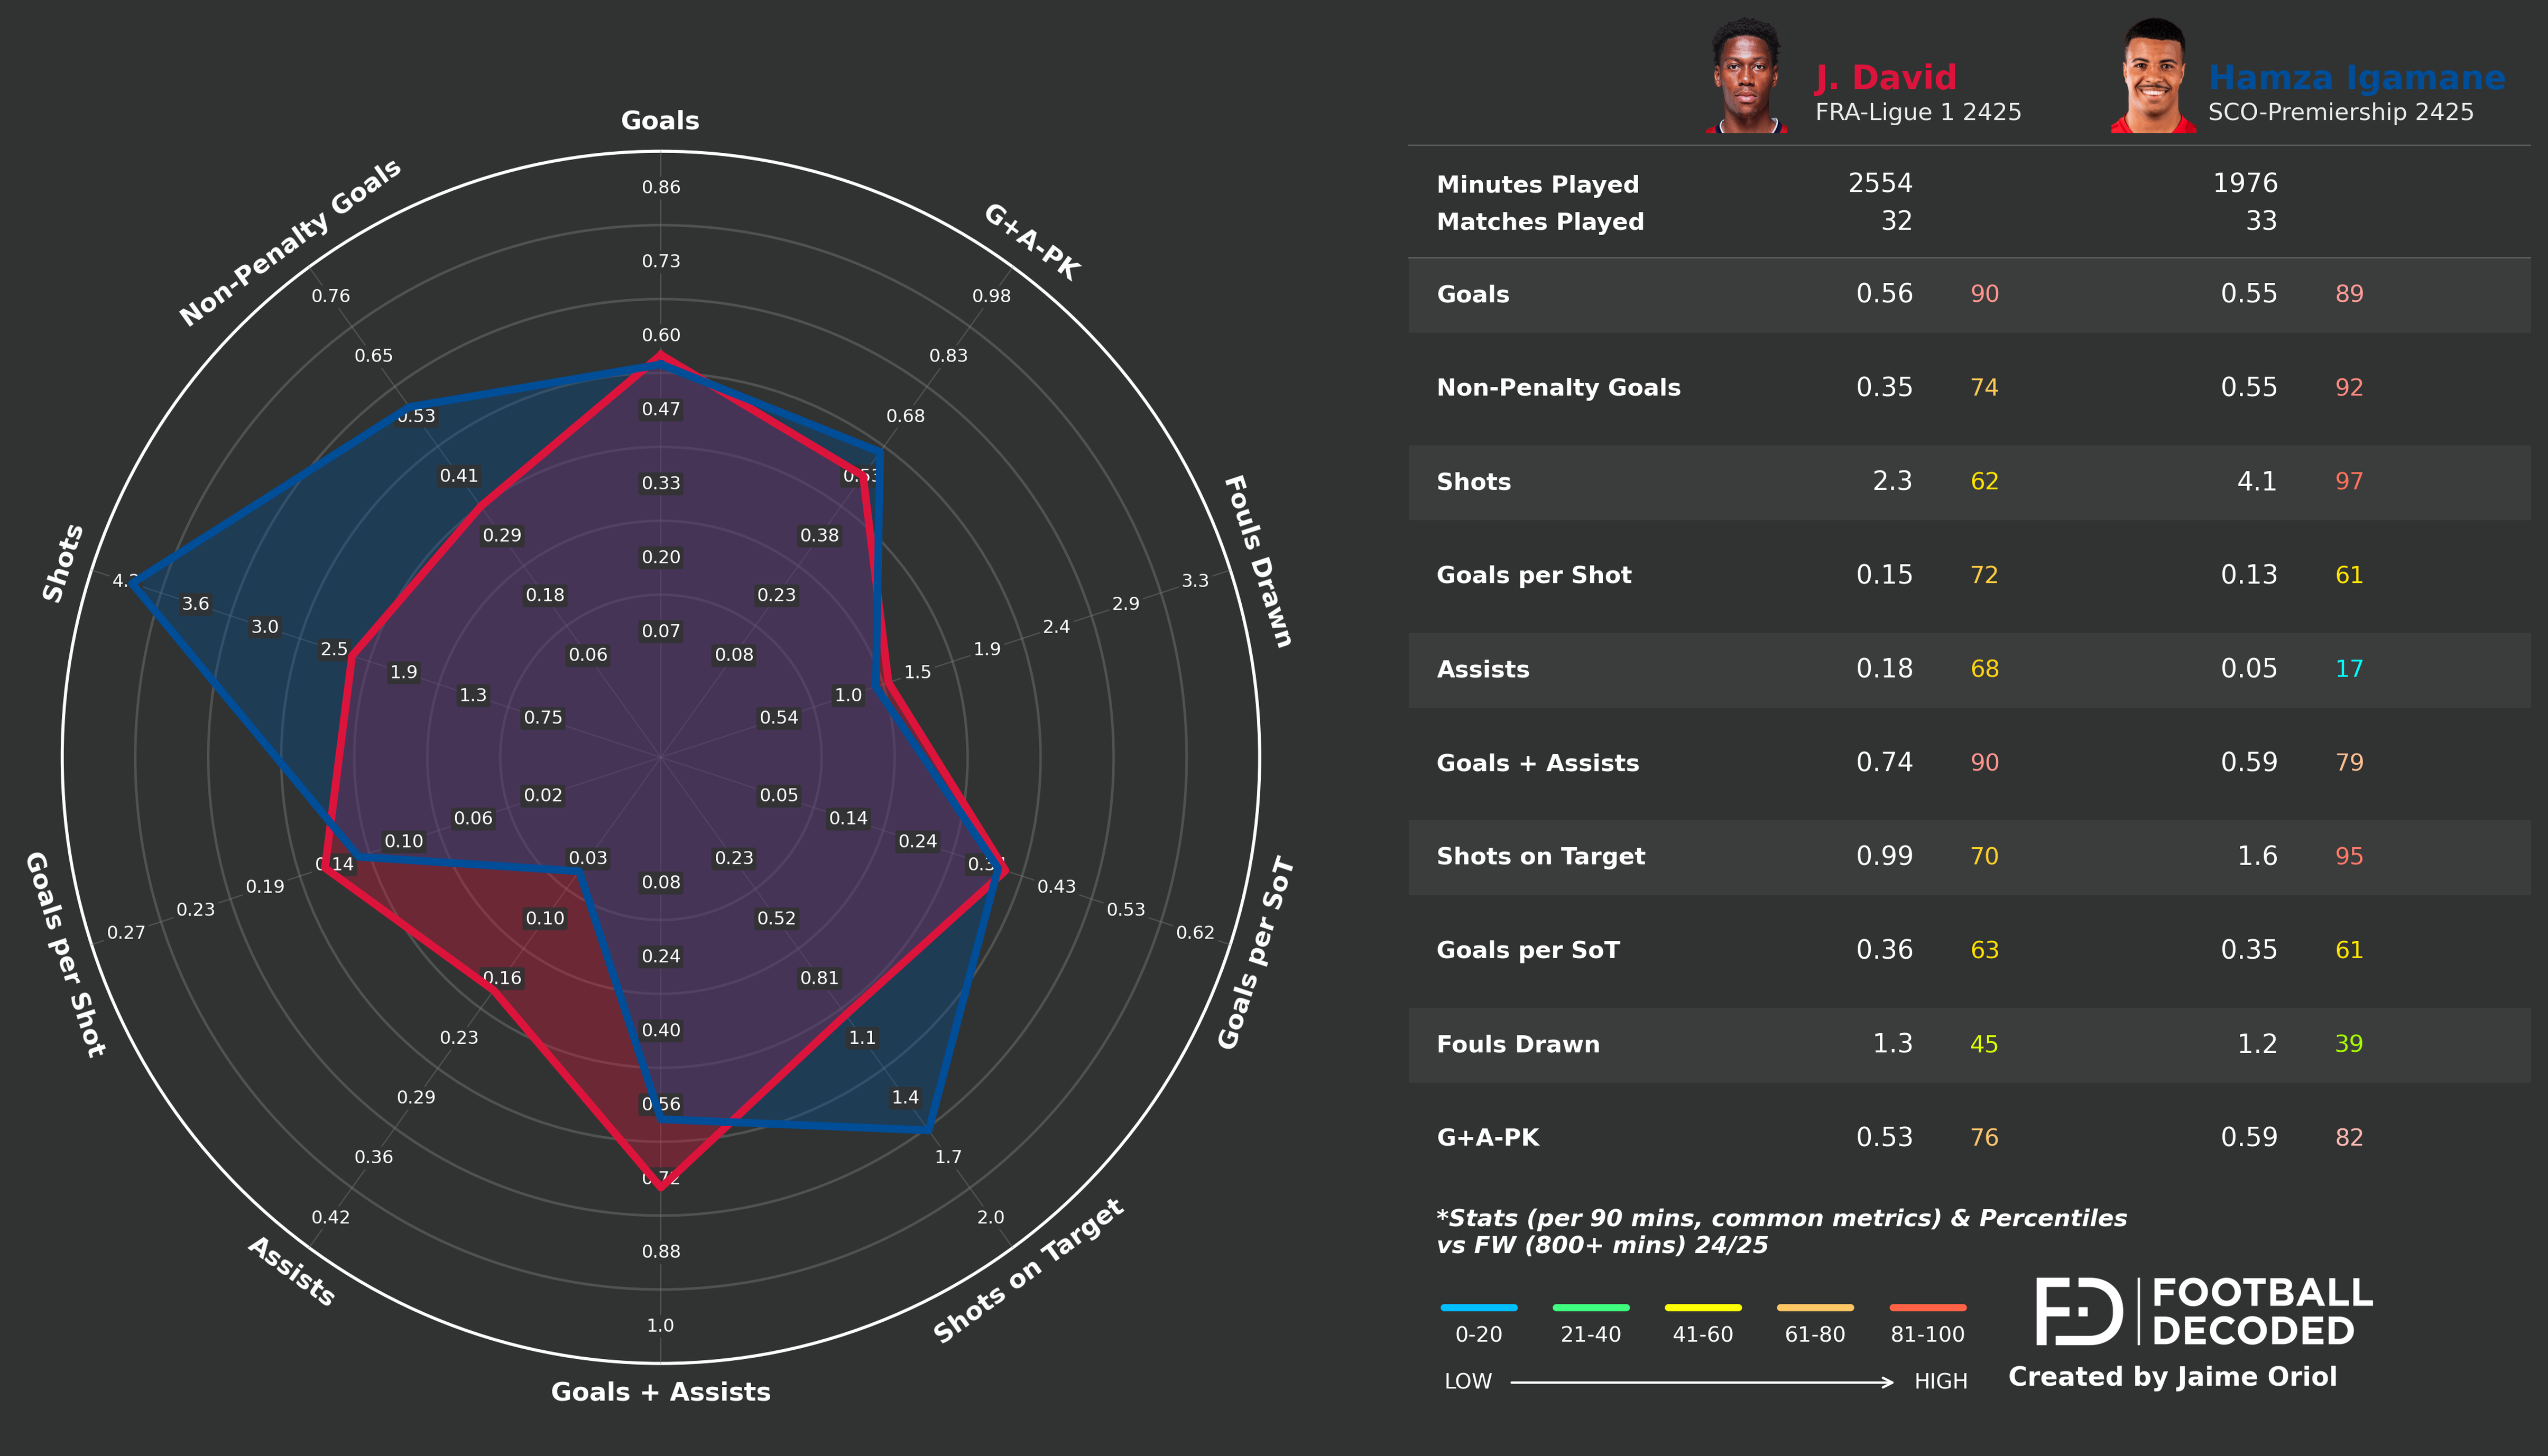


RADAR COMPARISON SUMMARY
✓ Radar generated successfully
Files saved in: ./david_igamane_radars/

IMPORTANT: Using COMMON metrics only (Escocia ∩ Big5)
  - NO xG metrics (not available in Scotland)
  - NO per100touches (Touches data not available)
  - Using per90 normalization with ~10 core metrics


In [13]:
from viz.swarm_radar import create_player_radar
from viz.stats_radar import create_stats_table, combine_radar_and_table
from IPython.display import Image as IPImage, display

print("FW/ST PLAYER RADAR GENERATION")
print("=" * 50)

comparison = COMPARISON
config_name = comparison['name']
player1_name = comparison['player1'] 
player2_name = comparison['player2']
title = comparison['title']
faces = comparison['faces']
colors = comparison['colors']
metrics_key = comparison['metrics_key']

print(f"\nProcessing: {title}")

if player1_name not in player_ids or player2_name not in player_ids:
    print(f"Missing player ID")
    print(f"  {player1_name}: {'Found' if player1_name in player_ids else 'Missing'}")
    print(f"  {player2_name}: {'Found' if player2_name in player_ids else 'Missing'}")
else:
    player1_id = player_ids[player1_name]
    player2_id = player_ids[player2_name]
    
    metrics_config = METRICS_BY_POSITION[metrics_key]
    metrics = metrics_config['metrics']
    metric_titles = metrics_config['titles']
    
    # Dataset FW
    position_df = df_final[df_final['position'].str.contains('FW', case=False, na=False)].copy()
    position_filter = "FW"
    
    print(f"  Dataset: {position_df.shape[0]} players ({position_filter})")
    
    # Team names
    player1_team = df_final.loc[df_final['unique_player_id'] == player1_id, 'team'].iloc[0]
    player2_team = df_final.loc[df_final['unique_player_id'] == player2_id, 'team'].iloc[0]
    
    team_colors = colors
    team_logos = {}
    if faces[0]:
        team_logos[player1_team] = faces[0]
    if len(faces) > 1 and faces[1]:
        team_logos[player2_team] = faces[1]
    
    print(f"  Teams: {player1_team} vs {player2_team}")
    print(f"  Colors: {colors}")
    
    try:
        create_player_radar(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=metrics,
            metric_titles=metric_titles,
            team_colors=team_colors,
            save_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            use_swarm=False,
            show_plot=False
        )
        
        create_stats_table(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=metrics,
            metric_titles=metric_titles,
            team_colors=team_colors,
            team_logos=team_logos,
            save_path=f"{SAVE_PATH_BASE}{config_name}_table.png",
            footer_text=f"Stats (per 90 mins, common metrics) & Percentiles\nvs {position_filter} ({MIN_MINUTES}+ mins) 24/25",
            show_plot=False
        )
        
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            table_path=f"{SAVE_PATH_BASE}{config_name}_table.png", 
            output_path=f"{SAVE_PATH_BASE}{config_name}_combined.png"
        )
        
        print(f"  ✓ Completed: {config_name}_combined.png")
        
        display(IPImage(f"{SAVE_PATH_BASE}{config_name}_combined.png"))
        
        print("\n" + "=" * 50)
        print("RADAR COMPARISON SUMMARY")
        print("=" * 50)
        print(f"✓ Radar generated successfully")
        print(f"Files saved in: {SAVE_PATH_BASE}")
        print(f"\nIMPORTANT: Using COMMON metrics only (Escocia ∩ Big5)")
        print(f"  - NO xG metrics (not available in Scotland)")
        print(f"  - NO per100touches (Touches data not available)")
        print(f"  - Using per90 normalization with ~{len(metrics)} core metrics")
        
    except Exception as e:
        print(f"  ✗ Error: {str(e)}")
        import traceback
        traceback.print_exc()